# PART 1: Bootstrapping Swap Curves

Group Members: 
1. Harshita Sachdev
2. Lu Tinjia
3. Rahul Sreeram
4. Srivatsa Sanjiv Mitragotri
5. Xie Zuoyu
6. Zhang Yonghan
7. Zhao Geping


In [42]:
import pandas as pd
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

Q1. Bootstrap OIS Discount Factor and Plot the Curve

Step 1: Load and Clean OIS Data

In [45]:
ois_df = pd.read_excel("IR Data.xlsx", sheet_name="OIS")
ois_df = ois_df.drop(["Unnamed: 3", "Unnamed: 4", "Unnamed: 5"], axis=1)
ois_df["Tenor"] = [0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30]

tenors_full = pd.DataFrame({"Tenor": np.arange(0.5, 30.5, 0.5)}) 
ois_full = pd.merge(tenors_full, ois_df, on="Tenor", how="left")
ois_full = ois_full.drop(columns=["Product"], errors="ignore")

ois_full["Discount Factor"] = np.nan
ois_full

,Tenor,Rate,Discount Factor
0,0.5,0.00250,NaN
1,1.0,0.00300,NaN
2,1.5,NaN,NaN
3,2.0,0.00325,NaN
4,2.5,NaN,NaN
5,3.0,0.00335,NaN
6,3.5,NaN,NaN
7,4.0,0.00350,NaN
8,4.5,NaN,NaN
9,5.0,0.00360,NaN


Step 2: Define Day Count and Helper Functions

In [47]:
DAY_COUNT = 360  
COUPON_FREQ = 2
def or_to_df(rate, days):
    return 1 / (1 + rate * days/DAY_COUNT)
def bootstrap_short_end(row):
    t = row["Tenor"]
    rate = row["Rate"]
    return or_to_df(rate, t)

Step 3: Bootstrap f0 and f1

In [49]:
f0 = ((ois_full.loc[0, "Tenor"] * ois_full.loc[0, "Rate"] + 1)**(1/180) - 1) * 360
ois_full.loc[0, "Discount Factor"] = or_to_df(f0, ois_full.loc[1, "Tenor"])

f1 = (((ois_full.loc[1, "Tenor"] * ois_full.loc[1, "Rate"] + 1) / (1 + f0 / 360)**180)**(1/180) - 1) * 360
ois_full.loc[1, "Discount Factor"] = 1 / ((1 + f0 / 360)**180 * (1 + f1 / 360)**180)

f0, f1

(np.float64(0.0024984474705913584), np.float64(0.0034925961006493367))

Step 4: Loop Bootstrap for Remaining Tenors

In [51]:
def swap_leg_pv(fixed_rate, dfs):
    """
    Return PV of fixed leg given known discount factors
    """
    times = np.arange(1, len(dfs) + 1)
    return fixed_rate * np.sum(dfs)
def floater_leg_pv(last_df):
    return 1 - last_df
known_dfs = ois_full["Discount Factor"].copy()
for i in range(3, len(ois_full)):
    if np.isnan(ois_full.loc[i, "Rate"]):
        continue
    fixed_rate = ois_full.loc[i, "Rate"]
    def objective(df_guess):
        all_dfs = known_dfs[1:i].dropna().tolist() + [df_guess]
        pv_fixed = swap_leg_pv(fixed_rate, all_dfs)
        pv_float = floater_leg_pv(df_guess)
        return pv_float - pv_fixed
    try:
        df_solved = brentq(objective, 0.01, 1.0)
        ois_full.loc[i, "Discount Factor"] = df_solved
        known_dfs[i] = df_solved
    except ValueError:
        continue
ois_result = ois_full.interpolate(method='linear')
ois_result.to_csv("ois_result.csv", index=False)

In [52]:
ois_result

,Tenor,Rate,Discount Factor
0,0.5,0.002500,0.999993
1,1.0,0.003000,0.997009
2,1.5,0.003125,0.995270
3,2.0,0.003250,0.993531
4,2.5,0.003300,0.991773
5,3.0,0.003350,0.990015
6,3.5,0.003425,0.988066
7,4.0,0.003500,0.986117
8,4.5,0.003550,0.984150
9,5.0,0.003600,0.982184


Step 5: Plot OIS Discount Curve

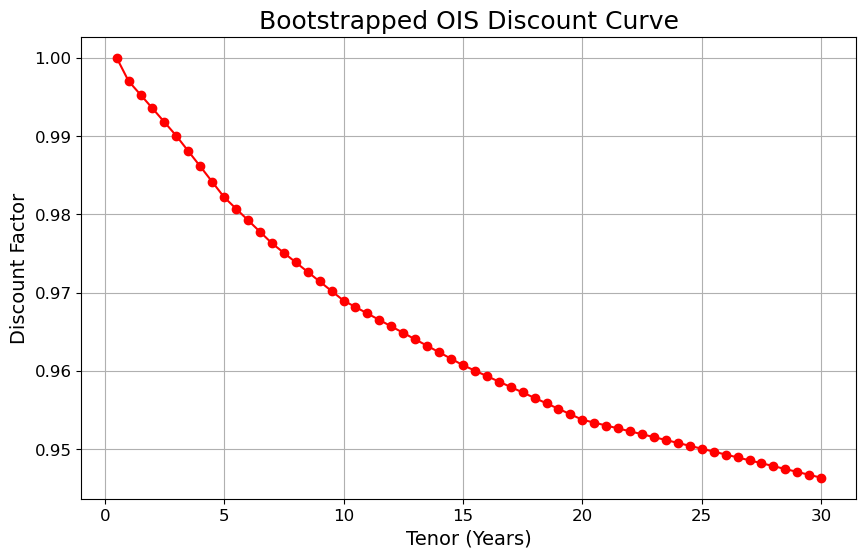

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(ois_result["Tenor"], ois_result["Discount Factor"], marker='o', linestyle='-', color="red")
plt.title("Bootstrapped OIS Discount Curve", fontsize=18)
plt.xlabel("Tenor (Years)", fontsize=14)
plt.ylabel("Discount Factor", fontsize=14)
plt.grid(True)
plt.tick_params(labelsize=12)  # optional: makes tick labels larger
plt.show()


Q2. Bootstrap LIBOR Discount Factor and Plot the Curve

In [56]:
irs_df = pd.read_excel("IR Data.xlsx", sheet_name="IRS")
irs_df = irs_df.drop(irs_df.columns[irs_df.columns.str.contains('Unnamed')], axis=1)
irs_df.columns = ['Product', 'Tenor', 'Rate']
irs_df['Tenor'] = [0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30]

tenors_full = pd.DataFrame({"Tenor": np.arange(0.5, 30.5, 0.5)})
irs_full = pd.merge(tenors_full, irs_df, on="Tenor", how="left")
irs_full["Discount Factor"] = np.nan
irs_full.loc[0, "Discount Factor"] = 1.0
irs_full

,Tenor,Product,Rate,Discount Factor
0,0.5,6m,0.0250,1.0
1,1.0,1y,0.0280,NaN
2,1.5,NaN,NaN,NaN
3,2.0,2y,0.0300,NaN
4,2.5,NaN,NaN,NaN
5,3.0,3y,0.0315,NaN
6,3.5,NaN,NaN,NaN
7,4.0,4y,0.0325,NaN
8,4.5,NaN,NaN,NaN
9,5.0,5y,0.0330,NaN


In [57]:
def bootstrap_ois_rate(known_dfs, known_times, current_tenor, fixed_rate):
    day_count = 360
    periods = int(current_tenor * 2) 
    
    def objective(df_guess):
        dfs = np.append(known_dfs, df_guess)
        times = np.append(known_times, current_tenor)
 
        fixed_pv = fixed_rate * sum(dfs * np.diff(times, prepend=0))

        float_pv = 1 - dfs[-1]
        
        return float_pv - fixed_pv

    df_solved = brentq(objective, 0.01, 1.0, xtol=1e-8)
    return df_solved

In [58]:
known_dfs = [1.0] 
known_times = [0.0]

In [59]:
for i in range(1, len(irs_full)):
    tenor = irs_full.loc[i, "Tenor"]
    rate = irs_full.loc[i, "Rate"]
    
    if pd.isna(rate):
        continue

    df = bootstrap_ois_rate(known_dfs, known_times, tenor, rate)
    irs_full.loc[i, "Discount Factor"] = df
    known_dfs.append(df)
    known_times.append(tenor)

irs_result = irs_full.interpolate(method='linear')
irs_result

/var/folders/lf/r12drgb548l1tt0ympt53njr0000gn/T/ipykernel_21990/1797828941.py:13: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  irs_result = irs_full.interpolate(method='linear')


,Tenor,Product,Rate,Discount Factor
0,0.5,6m,0.025000,1.000000
1,1.0,1y,0.028000,0.972763
2,1.5,NaN,0.029000,0.957652
3,2.0,2y,0.030000,0.942541
4,2.5,NaN,0.030750,0.926757
5,3.0,3y,0.031500,0.910972
6,3.5,NaN,0.032000,0.895266
7,4.0,4y,0.032500,0.879560
8,4.5,NaN,0.032750,0.864614
9,5.0,5y,0.033000,0.849668


In [60]:
irs_result

,Tenor,Product,Rate,Discount Factor
0,0.5,6m,0.025000,1.000000
1,1.0,1y,0.028000,0.972763
2,1.5,NaN,0.029000,0.957652
3,2.0,2y,0.030000,0.942541
4,2.5,NaN,0.030750,0.926757
5,3.0,3y,0.031500,0.910972
6,3.5,NaN,0.032000,0.895266
7,4.0,4y,0.032500,0.879560
8,4.5,NaN,0.032750,0.864614
9,5.0,5y,0.033000,0.849668


In [61]:
irs_result.to_csv("LIBOR.csv")

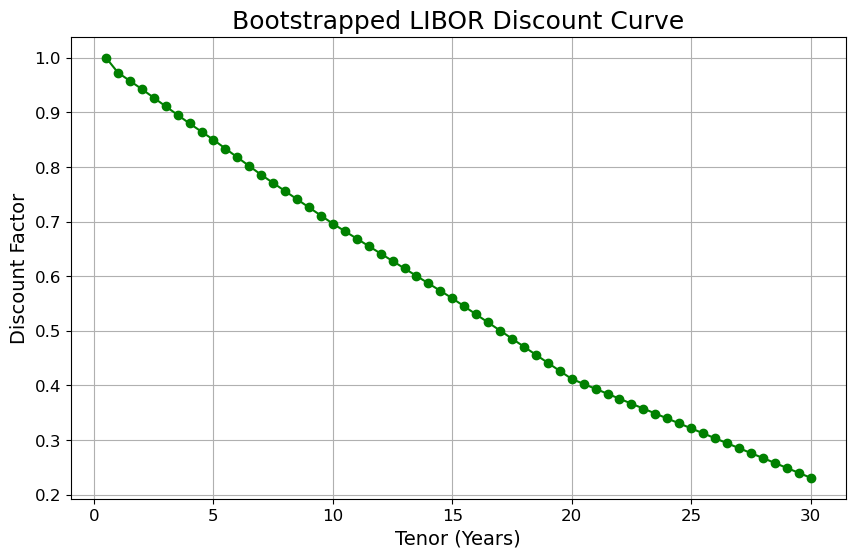

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(irs_result["Tenor"], irs_result["Discount Factor"], 
         marker='o', linestyle='-', color="green")
plt.title("Bootstrapped LIBOR Discount Curve", fontsize=18)
plt.xlabel("Tenor (Years)", fontsize=14)
plt.ylabel("Discount Factor", fontsize=14)
plt.grid(True)
plt.tick_params(labelsize=12)  # Makes axis tick labels larger
plt.show()


Q3. Calculate the forward swap rates for the following portfolios:  
    - Starting term 1 year x exchange term [1,2,3,5,10] years  
    - Starting term 5 years x exchange term [1,2,3,5,10] years  
    - Starting term 10 years x exchange term [1,2,3,5,10] years  

In [64]:
ois_curve = ois_result[['Tenor', 'Discount Factor']].rename(columns={'Discount Factor': 'OIS_DF'})
libor_curve = irs_result[['Tenor', 'Discount Factor', 'Rate']].rename(columns={'Discount Factor': 'LIBOR_DF'})
IRS_data_final = pd.merge(ois_curve, libor_curve, on='Tenor', how='outer').sort_values('Tenor')

IRS_data_final['LIBOR_Forward'] = (IRS_data_final['LIBOR_DF'].shift(1) - IRS_data_final['LIBOR_DF']) / IRS_data_final['LIBOR_DF'] / 0.5
IRS_data_final.loc[0, 'LIBOR_Forward'] = IRS_data_final.loc[0, 'Rate']

IRS_data_final = IRS_data_final.interpolate(method='linear')

def calculate_forward_swap_rate(expiry, tenor):
    """
    Calculate forward swap rate for given expiry and tenor
    expiry: start of swap (years)
    tenor: duration of swap (years)
    """
    start_idx = np.searchsorted(IRS_data_final['Tenor'], expiry)
    end_idx = np.searchsorted(IRS_data_final['Tenor'], expiry + tenor)

    payment_dates = np.arange(expiry + 0.5, expiry + tenor + 0.5, 0.5)

    float_leg_pv = 0.0
    annuity_pv = 0.0
    
    for t in payment_dates:
        idx = np.abs(IRS_data_final['Tenor'] - t).idxmin()
        df = IRS_data_final.loc[idx, 'OIS_DF']
        forward_rate = IRS_data_final.loc[idx, 'LIBOR_Forward']
        float_leg_pv += 0.5 * df * forward_rate
        annuity_pv += 0.5 * df
    
    return float_leg_pv / annuity_pv if annuity_pv != 0 else np.nan

combinations = [
    (1,1), (1,2), (1,3), (1,5), (1,10),
    (5,1), (5,2), (5,3), (5,5), (5,10),
    (10,1), (10,2), (10,3), (10,5), (10,10)
]

results = []
for expiry, tenor in combinations:
    rate = calculate_forward_swap_rate(expiry, tenor)
    results.append([f"{expiry}Y", f"{tenor}Y", rate])

forward_swap_rates = pd.DataFrame(results, 
                                columns=['Expiry', 'Tenor', 'Forward Swap Rate'])
print(forward_swap_rates.to_string(
    index=False,
    float_format="%.6f",
    header=True
))

Expiry Tenor  Forward Swap Rate
    1Y    1Y           0.031811
    1Y    2Y           0.033082
    1Y    3Y           0.033852
    1Y    5Y           0.035043
    1Y   10Y           0.037802
    5Y    1Y           0.038823
    5Y    2Y           0.039606
    5Y    3Y           0.039438
    5Y    5Y           0.040281
    5Y   10Y           0.042205
   10Y    1Y           0.040428
   10Y    2Y           0.041279
   10Y    3Y           0.042179
   10Y    5Y           0.044149
   10Y   10Y           0.053165
